## A simple notebook example of how to use the SAR-based ET estimation model for inference.

This example consists of steps of the inference procedure of the SAR-based ET estimation model. The steps are:
1. Defining the parameters for the model
2. Initializing the model and loading the model weights from a file
3. Loading the input data
4. Running the model on the input data
5. Saving the model outputs to a file
6. Plotting the model outputs



### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('../')

from modules import *
from config import *

### Define variables

In [2]:
# ---
pretrained_model = "../../models/et-estimator.pt"  # Path to pretrained SAR2ET model
# ---
example_idx = 8  # Index of the example to predict
s1_tensor = f"../../data/tensors/s1/s1_{example_idx:04}.pt"  # Path to input S1 tensor
era5_tensor = f"../../data/tensors/era5/era5_{example_idx:04}.pt" # Path to input ERA5 tensor
dem_tensor = f"../../data/tensors/dem/dem_{example_idx:04}.pt"  # Path to input DEM tensor
# ---
device = "cuda"  # Device to run model on (cuda or cpu)
# ---

### Initialize and load the pretrained model

In [3]:
# -------------------------------------------
# Initialize and load the pretrained model
# -------------------------------------------
# Initialize the network
et_estimator = UNet(d_in=N_CHANNELS, d_out=N_CLASSES)
# Load pretrained model weights
params = torch.load(pretrained_model)
# Load weights into the initialized network
et_estimator.load_state_dict(params["model_state_dict"])
# Set device to use for inference
et_estimator = et_estimator.to(device)
# Set model to evaluation mode
et_estimator.eval()
# ---
print("Pre-trained model is loaded.")

Pre-trained model is loaded.


### Load input data

In [4]:
# Load tensors
s1 = torch.load(s1_tensor)  # s1.shape = (1, 6, 128, 128) 
era5 = torch.load(era5_tensor)  # era5.shape = (1, 7, 128, 128)
dem = torch.load(dem_tensor)  # dem.shape = (1, 5, 128, 128)
print(f"Shapes of input tensors:\n\tS1\t: {s1.shape}\n\tERA5\t: {era5.shape}\n\tDEM\t: {dem.shape}")
# Concatenate tensors along the channel dimension
x = torch.cat([s1, era5, dem], dim=1).to(device)  # x.shape = (1, 18, 128, 128)
print(f"Input tensor shape after concatenation: {x.shape}")

Shapes of input tensors:
	S1	: torch.Size([1, 6, 128, 128])
	ERA5	: torch.Size([1, 7, 128, 128])
	DEM	: torch.Size([1, 5, 128, 128])
Input tensor shape after concatenation: torch.Size([1, 18, 128, 128])


### Inference

In [5]:
with torch.no_grad():  # Disable gradient calculation for efficiency
    # Pass through model
    et = et_estimator(x)  # et.shape = (1, 1, 128, 128)
    # Apply ReLU activation function
    et_pred = torch.relu(et)  # et_pred.shape = (1, 1, 128, 128)

print(f"Predicted ET tensor shape: {et_pred.shape}")

Predicted ET tensor shape: torch.Size([1, 1, 128, 128])


### Save results

In [6]:
# Save predicted ET tensor
torch.save(et_pred, "et_pred.pt")
# Save predicted ET tensor as a PNG image
plt.imshow(et_pred.squeeze().cpu().numpy(), cmap="coolwarm", vmin=0, vmax=8)
# remove axis
plt.axis("off")
plt.savefig("et_pred.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.close()

### Plot the results

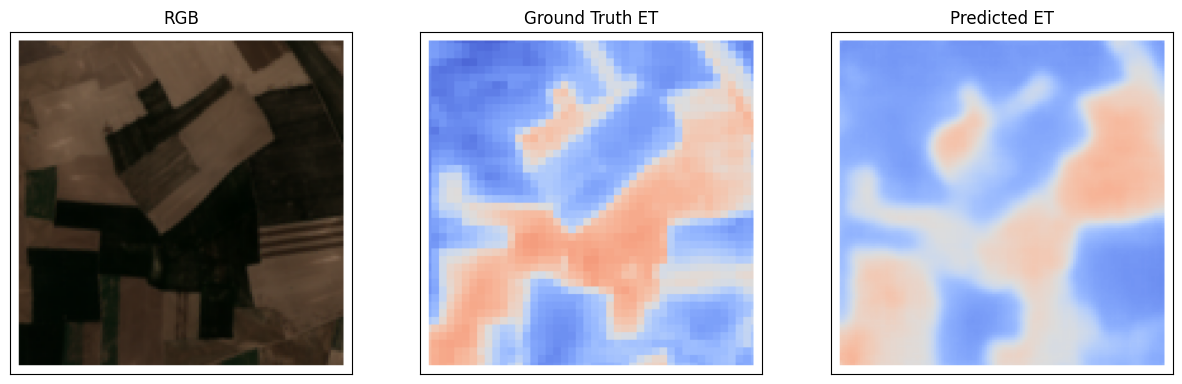

In [7]:
# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Load RGB and ground truth ET images
rgb = plt.imread(f"../../data/images/rgb/rgb_{example_idx:04}.png")
et_gt = plt.imread(f"../../data/images/et-gt/et_gt_{example_idx:04}.png")
et_pred = plt.imread("et_pred.png")

# Plot RGB, ground truth ET and predicted ET
axes[0].set_title("RGB")
axes[0].imshow(rgb)
axes[1].set_title("Ground Truth ET")
axes[1].imshow(et_gt, cmap="coolwarm", vmin=0, vmax=8)
axes[2].set_title("Predicted ET")
axes[2].imshow(et_pred, cmap="coolwarm", vmin=0, vmax=8)

# remove axes ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
# show plot
plt.show()